# NOTE
- General Layer - linear,batchnorm,dropout,activation,attention
- gnn layer - inital raw x, node embedding h0, ..., node embedding hn

# Tutorial: Fraud detection with Graph Attention Networks 
By Sing Kwan NG and Anthony TAING as part of the Stanford CS224W course project.
In this tutorial we will show you the fraud detection use case (for a node classification task) on Bitcoin dataset  by using the first version of GAT model and the GATv2 (Graph Attention Network model version2) .We will implement it by using our customs layers with PyG and the buitin PyG layers. 

# Setup


In [86]:
# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
import os

def unzip(location,**kwargs):
    import zipfile
    with zipfile.ZipFile(location,"r") as zip_ref:
        zip_ref.extractall(**kwargs)

def unzip_data(location):
    if not os.path.exists('data'):
        os.mkdir('data')
    unzip(location,path='data')

def is_colab():
    import sys
    return 'google.colab' in sys.modules

def init():
    if is_colab():
        repo_name = 'deep-learning-note'
        if repo_name not in os.listdir():
            !git clone https://github.com/taimoon/deep-learning-note
        %pip install torch_geometric
        torch_cuda_arg = r'https://data.pyg.org/whl/torch-2.0.0+cu118.html'
        %pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f {torch_cuda_arg}
        
        from google.colab import drive
        drive.mount('/content/drive')
        unzip('/content/drive/MyDrive/data science project/save_results.zip')
        drive_path = '/content/drive/MyDrive/data science project'
        unzip_data(drive_path + '/elliptic.zip')

# %pip install torch_geometric pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html

FOLDERNAME = "/content/" if is_colab() else "./"
init()
DATA_PATH = 'data/elliptic_bitcoin_dataset/'

## Load packages

In [88]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from sklearn.metrics import accuracy_score,f1_score,roc_auc_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split

import scipy.sparse as sp

# About Dataset

## Description
The Elliptic Data Set maps Bitcoin transactions to real entities belonging to licit categories (exchanges, wallet providers, miners, licit services, etc.) versus illicit ones (scams, malware, terrorist organizations, ransomware, Ponzi schemes, etc.). The task on the dataset is to classify the illicit and licit nodes in the graph.

If you make use of the Elliptic Data Set in your research, please consider citing:

[1] Elliptic, www.elliptic.co.
[2] M. Weber, G. Domeniconi, J. Chen, D. K. I. Weidele, C. Bellei, T. Robinson, C. E. Leiserson, "Anti-Money Laundering in Bitcoin: Experimenting with Graph Convolutional Networks for Financial Forensics", KDD ’19 Workshop on Anomaly Detection in Finance, August 2019, Anchorage, AK, USA.

## Content
This anonymized data set is a transaction graph collected from the Bitcoin blockchain. A node in the graph represents a transaction, an edge can be viewed as a flow of Bitcoins between one transaction and the other. Each node has 166 features and has been labeled as being created by a "licit", "illicit" or "unknown" entity.

## Nodes and edges
The graph is made of 203,769 nodes and 234,355 edges. Two percent (4,545) of the nodes are labelled class1 (illicit). Twenty-one percent (42,019) are labelled class2 (licit). The remaining transactions are not labelled with regard to licit versus illicit.

## Features
There are 166 features associated with each node. Due to intellectual property issues, we cannot provide an exact description of all the features in the dataset. There is a time step associated to each node, representing a measure of the time when a transaction was broadcasted to the Bitcoin network. The time steps, running from 1 to 49, are evenly spaced with an interval of about two weeks. **Each time step contains a single connected component of transactions that appeared on the blockchain within less than three hours between each other; there are no edges connecting the different time steps.**

The first 94 features represent local information about the transaction – including the time step described above, number of inputs/outputs, transaction fee, output volume and aggregated figures such as average BTC received (spent) by the inputs/outputs and average number of incoming (outgoing) transactions associated with the inputs/outputs. The remaining 72 features are aggregated features, obtained using transaction information one-hop backward/forward from the center node - giving the maximum, minimum, standard deviation and correlation coefficients of the neighbour transactions for the same information data (number of inputs/outputs, transaction fee, etc.).

## License
This data set is distributed under the Creative CommonsAttribution-NonCommercial-NoDerivatives License 4.0 International.

# Data ETL - E

We have hosted the dataset on Gdrive to the public for convenience for one click download. However, the original data is hosted on kaggle as well. If you want to download data from Kaggle using API(if you already have an account) or get it manually from: https://www.kaggle.com/ellipticco/elliptic-data-set.

In [89]:
Download=False
if Download:
    !gdown --id 1CIFpAquzYBA98gQCdMb92fC0w6yrYf2m
    !gdown --id 1Cfh0VIXWTc8EK96WRZdyaqgA2-JwvsUG
    !gdown --id 1Cfh8hA9Tl8uCPrLSmcIQI3qCbEjOFl7C
    DATA_PATH = FOLDERNAME

## Load data

In [90]:
# Load data from the folder
df_features = pd.read_csv(DATA_PATH+'elliptic_txs_features.csv',header=None)
df_edges = pd.read_csv(DATA_PATH+"elliptic_txs_edgelist.csv")
df_classes =  pd.read_csv(DATA_PATH+"elliptic_txs_classes.csv")

In [91]:
contain_null = lambda df : df.isnull().any().any()
assert(not contain_null(df_features))
assert(not contain_null(df_edges))
assert(not contain_null(df_classes))

In [92]:
# reformat classes 0:licit, 1:illicit, 2:unknown
idx_to_class = ['Licit','Illicit','Unknown']
df_classes['class'] = df_classes['class'].map({'unknown': 2, '1':1, '2':0}) 

<BarContainer object of 3 artists>

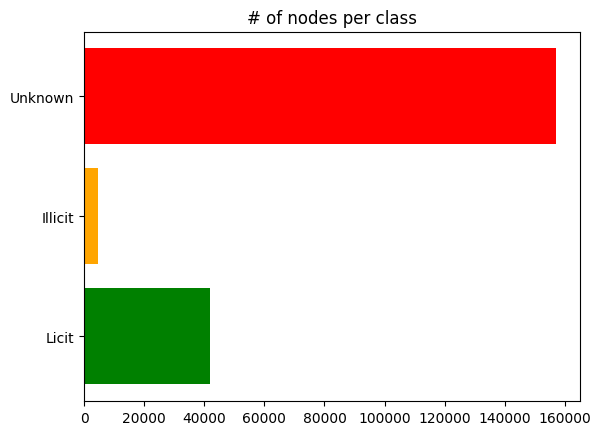

In [93]:
# See repartition of nodes per class
group_class = df_classes.groupby('class').count()
plt.title("# of nodes per class")
plt.barh(idx_to_class, group_class['txId'].values, color=['g', 'orange', 'r'] )

# EDA - Preview of data features, edges and their labels

In [94]:
# View node features
# Data is each node is a transaction ID, and edges are a bit weird, but its like a "previous transaction" edge type
# column 0 = transaction id, column 1 = time step
# first 94 = info of transaction
# remaining 72 = aggregrated
df_features.head()

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


In [95]:
# See edges
df_edges.head()

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206


In [96]:
# See classes
df_classes.head()

,txId,class
0,230425980,2
1,5530458,2
2,232022460,2
3,232438397,0
4,230460314,2


## Visualization

<Axes: ylabel='Frequency'>

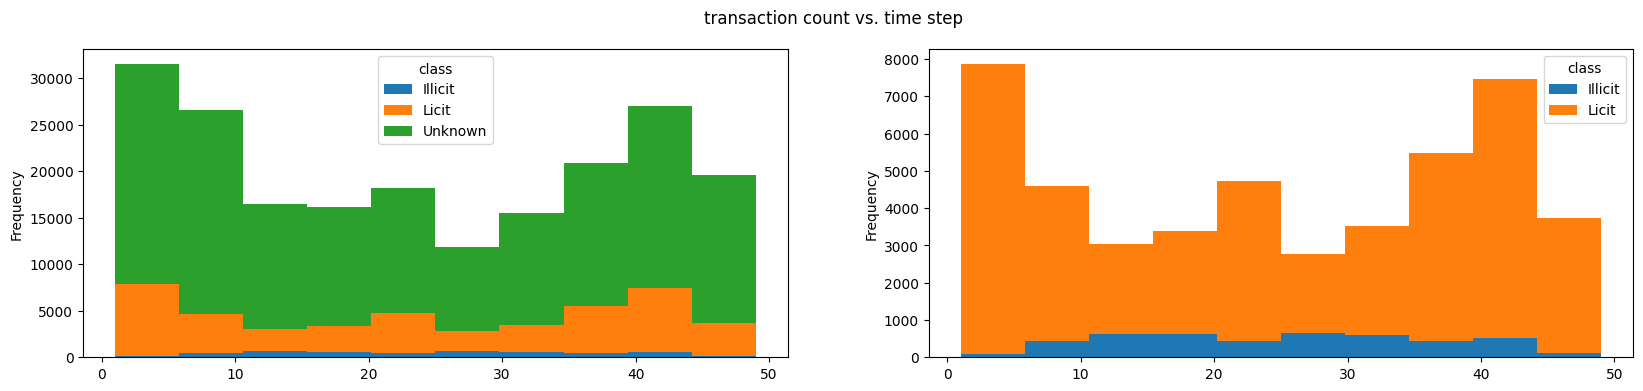

In [97]:
df_tmp = pd.merge(df_features,df_classes,how='left',left_on=0,right_on='txId')[[1,'class']]
df_tmp['class'] = df_tmp['class'].map(lambda i : idx_to_class[i])

fig,axs= plt.subplots(1,2,figsize=(20,4))
fig.suptitle('transaction count vs. time step')
df_tmp.pivot(columns='class')[1].plot(kind = 'hist', stacked=True,ax=axs[0])

df_tmp[df_tmp['class'] != 'Unknown'].pivot(columns='class')[1].plot(kind = 'hist', stacked=True,ax=axs[1])

In [98]:
import networkx as nx

def construct_graph():
    G = nx.DiGraph()
    
    df_merge = df_edges.merge(df_features,how='left',left_on='txId1',right_on=0)
    
    edges = df_merge[['txId1','txId2',1]]

    edges = edges.values
    edges = [(u,v,{'t':t}) for u,v,t in edges]
    
    G.add_edges_from(edges)
    
    nodes = df_features[[0,1]]
    nodes = nodes.merge(df_classes, how='left',left_on=0,right_on='txId')

    
    nodes = nodes[[0,1,'class']].values
    nodes = [(u,{'t':t,'label':y}) for u,t,y in nodes]
    G.add_nodes_from(nodes)
    return G


G = construct_graph()

(<Figure size 2000x500 with 1 Axes>, <Axes: >)

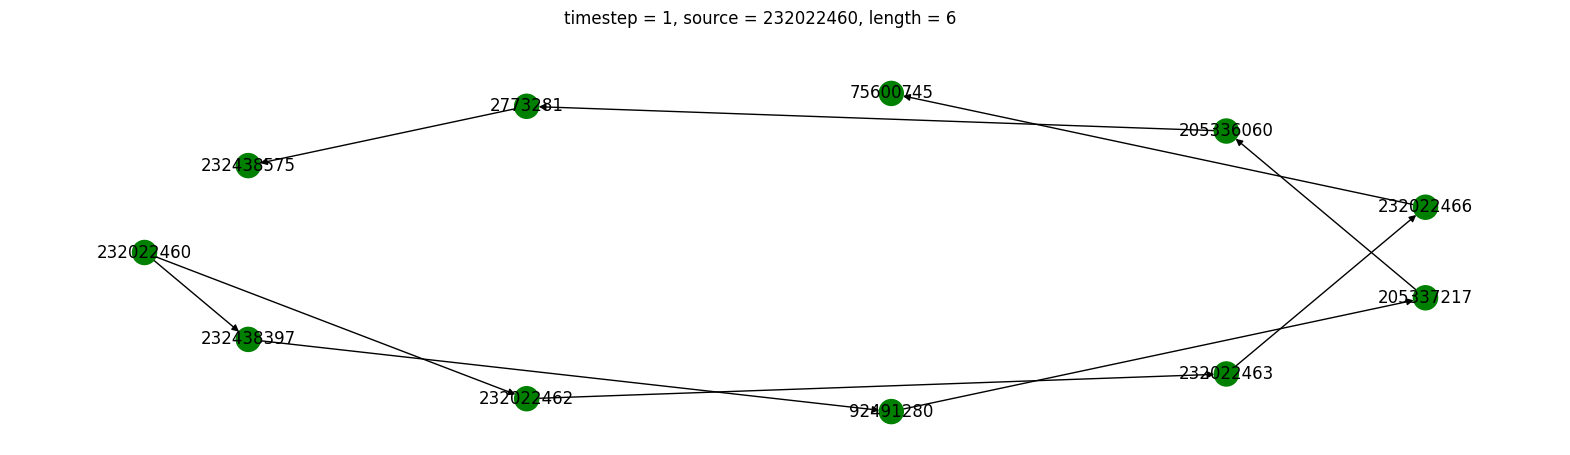

In [99]:
def construct_bfs_tree(G,src):
    g = nx.bfs_tree(G,src)
    g = nx.DiGraph(g)
    attributes = nx.get_edge_attributes(G, 't')
    nx.set_edge_attributes(g, attributes, 't')
    attributes = nx.get_node_attributes(G, 't')
    nx.set_node_attributes(g, attributes, 't')
    
    attributes = nx.get_node_attributes(G, 'label')
    nx.set_node_attributes(g, attributes, 'label')
    return g

def plot_bfs(G,src=None):
    from random import choice

    if src is None:
        src = choice(list(G.nodes))

    g = construct_bfs_tree(G,src)
    
    labels = {n:n for n in g}
    cmap = ['red' if g.nodes[n]['label'] == 1  else 'green' for n in g.nodes] 
    
    pos = nx.shell_layout(g)
    fig,ax = plt.subplots(1,1,figsize=(20,5))
    length = nx.dag_longest_path_length(g)
    fig.suptitle(f'timestep = {g.nodes[src]["t"]}, source = {src}, length = {length}')
    nx.draw(g,pos,node_color=cmap,labels=labels,ax=ax)
    return fig,ax

plot_bfs(G,232022460)

(<Figure size 2000x500 with 1 Axes>, <Axes: >)

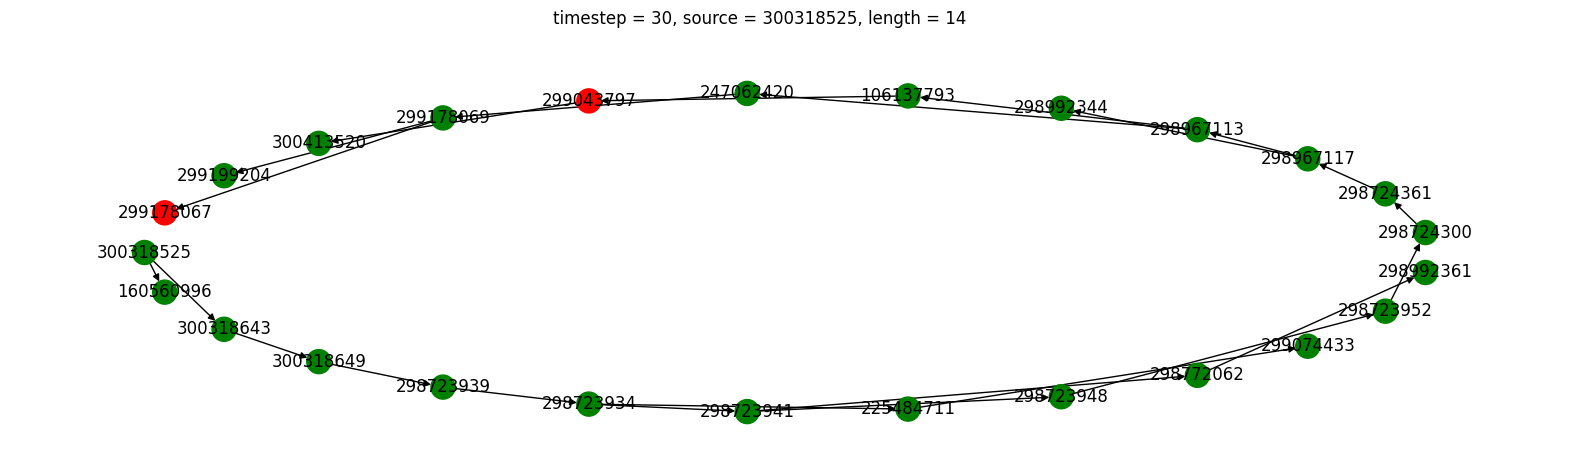

In [100]:
plot_bfs(G,300318525)

(<Figure size 2000x500 with 1 Axes>, <Axes: >)

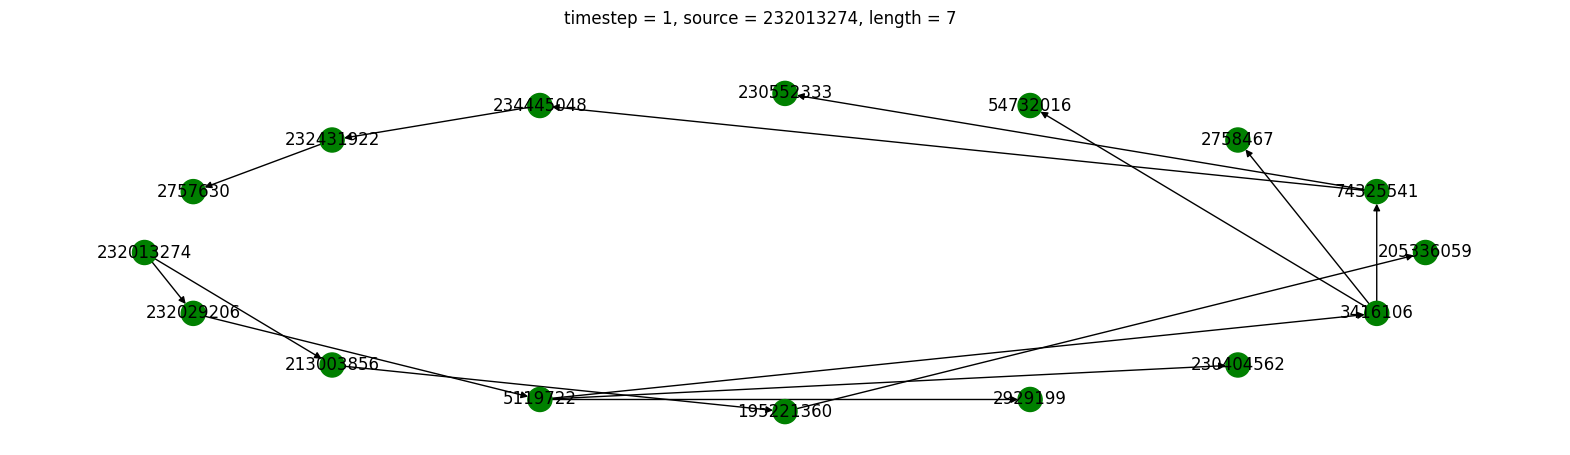

In [101]:
plot_bfs(G,232013274)

(<Figure size 2000x500 with 1 Axes>, <Axes: >)

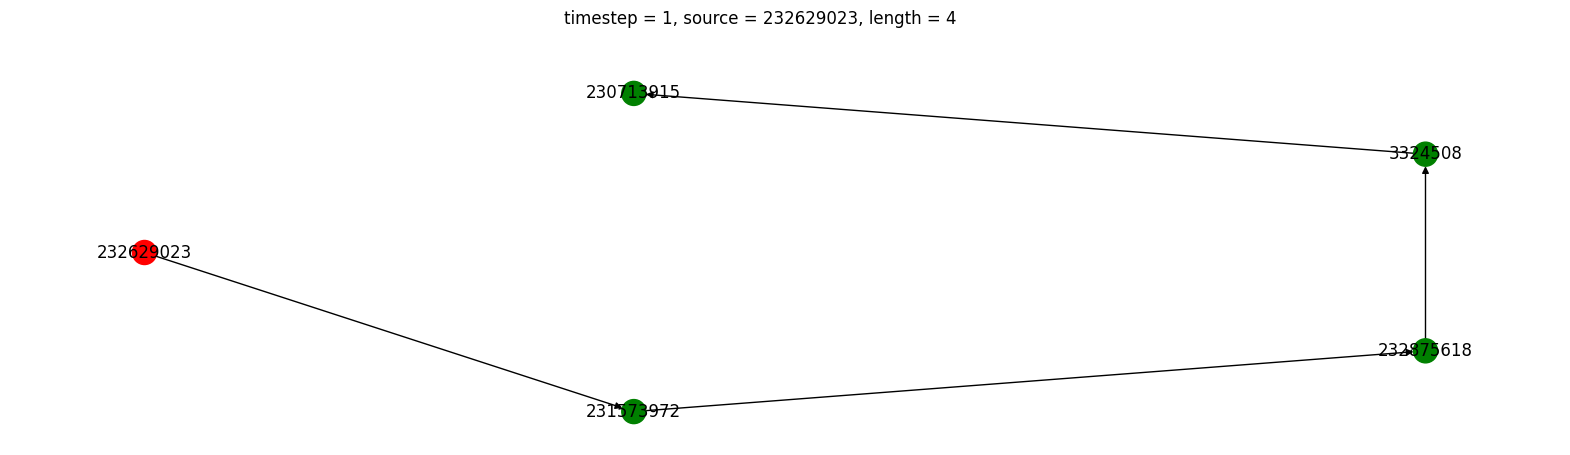

In [102]:
plot_bfs(G,232629023)

# Data ETL - TL

## Merge dataset

In [103]:
tmp1 = pd.merge(df_edges,df_features[[0,1]],how='left',left_on='txId1',right_on=0)
tmp2 = pd.merge(df_edges,df_features[[0,1]],how='left',left_on='txId2',right_on=0)
res = tmp1[1] == tmp2[1]
res.all()

True

In [104]:
# Merge features with classes
df_merge = df_features.merge(df_classes, how='left', left_on=0, right_on="txId")
# df_merge = df_features.merge(df_classes, how='left', left_on=0, right_on="txId").sort_values(1).reset_index(drop=True)
df_merge

,0,1,2,3,4,5,6,7,8,9,...,159,160,161,162,163,164,165,166,txId,class
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,230425980,2
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,5530458,2
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792,232022460,2
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,232438397,0
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117,230460314,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203764,173077460,49,-0.145771,-0.163752,0.463609,-0.121970,-0.043875,-0.113002,-0.061584,-0.135803,...,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,173077460,2
203765,158577750,49,-0.165920,-0.123607,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.156418,...,1.461330,1.461369,-0.098889,-0.087490,-0.084674,-0.140597,-1.760926,-1.760984,158577750,2
203766,158375402,49,-0.172014,-0.078182,1.018602,0.028105,-0.043875,0.054722,-0.061584,-0.163626,...,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,158375402,1
203767,158654197,49,-0.172842,-0.176622,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.163501,...,1.461330,1.461369,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399,158654197,2


In [105]:
df_merged_edges = df_edges.merge(df_features[[0,1]],how='left',left_on='txId1',right_on=0)
df_merged_edges.head()

,txId1,txId2,0,1
0,230425980,5530458,230425980,1
1,232022460,232438397,232022460,1
2,230460314,230459870,230460314,1
3,230333930,230595899,230333930,1
4,232013274,232029206,232013274,1


In [106]:
# Setup trans ID to node ID mapping
def temporal_split(t = 1):
    # ---- #
    NODE_ID_COL,TIMESTEP_COL = 0,1
    df = df_merge[df_merge[TIMESTEP_COL] == t]
    df = df.sort_values(0).reset_index(drop=True)

    nodes = df[NODE_ID_COL].values
    node_to_id = {j:i for i,j in enumerate(nodes)}

    edges = df_merged_edges[df_merged_edges[TIMESTEP_COL] == t]
    edges = edges.drop(columns=[NODE_ID_COL,TIMESTEP_COL])
    edges.txId1 = edges.txId1.map(node_to_id)
    edges.txId2 = edges.txId2.map(node_to_id)
    edge_index = torch.tensor(edges.values.astype(int)).T.long().contiguous() # create a tensor

    # set all edge weights to be 1
    weights = torch.tensor([1] * edge_index.shape[1] , dtype=torch.double)
    
    labels = df['class'].values

    # mapping txIds to corresponding indices, to pass node features to the model
    node_features = df.drop(['txId'], axis=1).copy()
    transID_to_nodeID = lambda: node_features[NODE_ID_COL].map(node_to_id)
    node_features[NODE_ID_COL] = transID_to_nodeID()

    # Retain known vs unknown ID
    classified_idx = node_features['class'][node_features['class']!=2].index
    unclassified_idx = node_features['class'][node_features['class']==2].index

    classified_illicit_idx = node_features['class'][node_features['class']==1].index
    classified_licit_idx = node_features['class'][node_features['class']==0].index
    
    node_features = node_features.drop(columns=[NODE_ID_COL, TIMESTEP_COL, 'class'])

    node_features_t = torch.tensor(np.array(node_features.values, dtype=np.double), dtype=torch.double)

    
    from torch_geometric.data import Data, DataLoader
    data = Data(x=node_features_t, edge_index=edge_index, edge_attr=weights, 
                                y=torch.tensor(labels, dtype=torch.double))
    # Add in the train and valid idx
    data.id_to_node = {j:i for i,j in node_to_id.items()}
    data.classified_idx = classified_idx
    data.classified_illicit_idx = classified_illicit_idx
    data.classified_licit_idx = classified_licit_idx
    data.unclassified_idx = unclassified_idx
    
    return data

In [107]:
def fn():
    for t in range(1,50):
        data = temporal_split(t)
        data.edge_index
        restored = [(data.id_to_node[a.item()],data.id_to_node[b.item()]) for a,b in data.edge_index.T]
        restored = np.array(restored)
        edges = df_merged_edges[df_merged_edges[1] == t]
        edges = edges.drop(columns=[0,1])
        # edges
        res = restored == edges.values
        assert(res.all() is np.bool_(True))
        
        df = df_features[df_features[1] == t].sort_values(0)[range(2,166+1)]
        res = torch.tensor(df.values) == data.x
        assert(res.all().item() is True)
# fn()

# Create a PyG dataset

Each PyG dataset stores a list of `torch_geometric.data.Data` objects, where each `torch_geometric.data.Data` object represents a graph. We can easily get the `Data` object by indexing into the dataset.

For more information such as what is stored in the `Data` object, please refer to the [documentation](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data).

We convert data to PyGeometric graph data format by using node_features, edge_index, weights and labels initialized before.

In [108]:
train_data = [temporal_split(t) for t in range(1,34+1)]
test_data = [temporal_split(t) for t in range(34,49+1)]

In [109]:
for data in train_data:
    train_idx, valid_idx = train_test_split(data.classified_idx.values, test_size=0.15, random_state=42)
    data.train_idx = train_idx
    data.valid_idx = valid_idx

In [110]:
import networkx as nx
import torch_geometric.utils as pyg_utils
nx.write_gexf(pyg_utils.to_networkx(train_data[0]),"./save_results/fraud.gexf")

# Model setup


In [111]:
import torch
import torch_scatter
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

from torch import Tensor

from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType,
                                    OptTensor)

from torch.nn import Parameter, Linear
from torch_sparse import SparseTensor, set_diag
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax, degree

import pickle

## Prebuilt with PyG's built-in  layers
In this section, we are using PyG's built-in layers with 2 layers and an additional MLP layers for the GATs models.

### GCNConv

In [112]:
class GCN(nn.Module):
    def __init__(self,seed=12345):
        super(GCN, self).__init__()
        torch.manual_seed(seed)
        self.conv1 = pyg_nn.GCNConv(165,128)
        self.conv2 = pyg_nn.GCNConv(128,2)
        self.classifier = Linear(2, 1)

    def forward(self, data, adj=None):
        x, edge_index = data.x, data.edge_index
        h = self.conv1(x, edge_index)
        h = F.tanh(h)
        h = self.conv2(h, edge_index)
        embeddings = F.tanh(h)  # Final GNN embedding space.
        
        # Apply a final (linear) classifier.
        out = self.classifier(embeddings)

        # return out, embeddings
        return F.sigmoid(out)

### GATConv


In [113]:
class GAT(nn.Module):
    def __init__(self,input_dim, hidden_dim, output_dim,args):
        self.args = args
        super(GAT, self).__init__()
        # use our gat message passing 
        self.conv1 = pyg_nn.GATConv(input_dim, hidden_dim, heads=args['heads'])
        self.conv2 = pyg_nn.GATConv(args['heads'] * hidden_dim, hidden_dim, heads=args['heads'])
        
        self.post_mp = nn.Sequential(
            nn.Linear(args['heads'] * hidden_dim, hidden_dim), 
            nn.Dropout(args['dropout'] ), 
            nn.Linear(hidden_dim, output_dim),)
        
    def forward(self, data, adj=None):
        args = self.args
        x, edge_index = data.x, data.edge_index
        # Layer 1
        x = self.conv1(x, edge_index)
        x = F.dropout(F.relu(x), p=args['dropout'], training=self.training)
        # Layer 2
        x = self.conv2(x, edge_index)
        x = F.dropout(F.relu(x), p=args['dropout'], training=self.training)
        # MLP output
        x = self.post_mp(x)
        return F.sigmoid(x)
       

### GATv2Conv 

In [114]:
class GATv2(nn.Module):
    def __init__(self,input_dim, hidden_dim, output_dim,args):
        self.args = args
        super(GATv2, self).__init__()
        #use our gat message passing 
        self.conv1 = pyg_nn.GATv2Conv(input_dim, hidden_dim, heads=args['heads'])
        self.conv2 = pyg_nn.GATv2Conv(args['heads'] * hidden_dim, hidden_dim, heads=args['heads'])
        
        self.post_mp = nn.Sequential(
            nn.Linear(args['heads'] * hidden_dim, hidden_dim), 
            nn.Dropout(args['dropout'] ), 
            nn.Linear(hidden_dim, output_dim))
        
    def forward(self, data, adj=None):
        args = self.args
        x, edge_index = data.x, data.edge_index
        # Layer 1
        x = self.conv1(x, edge_index)
        x = F.dropout(F.relu(x), p=args['dropout'], training=self.training)
        # Layer 2
        x = self.conv2(x, edge_index)
        x = F.dropout(F.relu(x), p=args['dropout'], training=self.training)
        # MLP output
        x = self.post_mp(x)
        return F.sigmoid(x)

## Custom GAT Implementation

Attention mechanisms have become the state-of-the-art in many sequence-based tasks such as machine translation and learning sentence representations. One of the major benefits of attention-based mechanisms is their ability to focus on the most relevant parts of the input to make decisions. In this problem, we will see how attention mechanisms can be used to perform node classification over graph-structured data through the usage of Graph Attention Networks (GATs) ([Veličković et al. (2018)](https://arxiv.org/abs/1710.10903)).

The building block of the Graph Attention Network is the graph attention layer, which is a variant of the aggregation function. Let $N$ be the number of nodes and $F$ be the dimension of the feature vector for each node. The input to each graph attentional layer is a set of node features: $\mathbf{h} = \{\overrightarrow{h_1}, \overrightarrow{h_2}, \dots, \overrightarrow{h_N}$\}, $\overrightarrow{h_i} \in R^F$. The output of each graph attentional layer is a new set of node features, which may have a new dimension $F'$: $\mathbf{h'} = \{\overrightarrow{h_1'}, \overrightarrow{h_2'}, \dots, \overrightarrow{h_N'}\}$, with $\overrightarrow{h_i'} \in \mathbb{R}^{F'}$.

We will now describe how this transformation is performed for each graph attention layer. First, a shared linear transformation parametrized by the weight matrix $\mathbf{W} \in \mathbb{R}^{F' \times F}$ is applied to every node. 

Next, we perform self-attention on the nodes. We use a shared attention function $a$:
\begin{equation} 
a : \mathbb{R}^{F'} \times \mathbb{R}^{F'} \rightarrow \mathbb{R}.
\end{equation}

that computes the attention coefficients capturing the importance of node $j$'s features to node $i$:
\begin{equation}
e_{ij} = a(\mathbf{W_l}\overrightarrow{h_i}, \mathbf{W_r} \overrightarrow{h_j})
\end{equation}

The most general formulation of self-attention allows every node to attend to all other nodes which drops all structural information. However, to utilize graph structure in the attention mechanisms, we use **masked attention**. In masked attention, we only compute attention coefficients $e_{ij}$ for nodes $j \in \mathcal{N}_i$ where $\mathcal{N}_i$ is some neighborhood of node $i$ in the graph.

To easily compare coefficients across different nodes, we normalize the coefficients across $j$ using a softmax function:
\begin{equation}
\alpha_{ij} = \text{softmax}_j(e_{ij}) = \frac{\exp(e_{ij})}{\sum_{k \in \mathcal{N}_i} \exp(e_{ik})}
\end{equation}

For this problem, our attention mechanism $a$ will be a single-layer feedforward neural network parametrized by a weight vectors $\overrightarrow{a_l} \in \mathbb{R}^{F'}$ and $\overrightarrow{a_r} \in \mathbb{R}^{F'}$, followed by a LeakyReLU nonlinearity (with negative input slope 0.2). Let $\cdot^T$ represent transposition and $||$ represent concatenation. The coefficients computed by our attention mechanism may be expressed as:

\begin{equation}
\alpha_{ij} = \frac{\exp\Big(\text{LeakyReLU}\Big(\overrightarrow{a_l}^T \mathbf{W_l} \overrightarrow{h_i} + \overrightarrow{a_r}^T\mathbf{W_r}\overrightarrow{h_j}\Big)\Big)}{\sum_{k\in \mathcal{N}_i} \exp\Big(\text{LeakyReLU}\Big(\overrightarrow{a_l}^T \mathbf{W_l} \overrightarrow{h_i} + \overrightarrow{a_r}^T\mathbf{W_r}\overrightarrow{h_k}\Big)\Big)}
\end{equation}

For the following questions, we denote `alpha_l` = $\alpha_l = [...,\overrightarrow{a_l}^T \mathbf{W_l} \overrightarrow{h_i},...] \in \mathcal{R}^n$ and `alpha_r` = $\alpha_r = [..., \overrightarrow{a_r}^T \mathbf{W_r} \overrightarrow{h_j}, ...] \in \mathcal{R}^n$.


At every layer of GAT, after the attention coefficients are computed for that layer, the aggregation function can be computed by a weighted sum of neighborhood messages, where weights are specified by $\alpha_{ij}$.

Now, we use the normalized attention coefficients to compute a linear combination of the features corresponding to them. These aggregated features will serve as the final output features for every node.

\begin{equation}
h_i' = \sum_{j \in \mathcal{N}_i} \alpha_{ij} \mathbf{W_r} \overrightarrow{h_j}.
\end{equation}  

### Multi-Head Attention
To stabilize the learning process of self-attention, we use multi-head attention. To do this we use $K$ independent attention mechanisms, or ``heads'' compute output features as in the above equations. Then, we concatenate these output feature representations:

\begin{equation}
    \overrightarrow{h_i}' = ||_{k=1}^K \Big(\sum_{j \in \mathcal{N}_i} \alpha_{ij}^{(k)} \mathbf{W_r}^{(k)} \overrightarrow{h_j}\Big)
\end{equation}

where $||$ is concentation, $\alpha_{ij}^{(k)}$ are the normalized attention coefficients computed by the $k$-th attention mechanism $(a^k)$, and $\mathbf{W}^{(k)}$ is the corresponding input linear transformation's weight matrix. Note that for this setting, $\mathbf{h'} \in \mathbb{R}^{KF'}$.

### Custom GAT model
PyG provides the MessagePassing base class, which helps in creating such kinds of message passing graph neural networks by automatically taking care of message propagation. \\
-**MessagePassing()**: Defines the aggregation scheme to use ("add", "mean" or "max") and the flow direction of message passing (either "source_to_target" or "target_to_source").  

-**MessagePassing.propagate(edge_index,size=None,kwargs)**: The initial call to start propagating messages. Takes in the edge indices and all additional data which is needed to construct messages and to update node embeddings. 

-**MessagePassing.message(...)**: Constructs messages to node  for each edge. It can take any argument which was initially passed to propagate().  In addition, tensors passed to propagate() can be mapped to the respective nodes and by appending _i or _j to the variable name.
We generally refer to i as the central nodes that aggregates information, and refer to j as the neighboring nodes, since this is the most common notation.

 Further details can be found at the official PyG documentation. 

In [115]:
class myGAT(MessagePassing):
    def __init__(self, in_channels, out_channels, heads = 1, 
                 negative_slope = 0.2, dropout = 0., **kwargs):
        super(myGAT, self).__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels # node features input dimension
        self.out_channels = out_channels # node level output dimension
        self.heads = heads # No. of attention heads
        self.negative_slope = negative_slope
        self.dropout = dropout

        self.lin_l = None
        self.lin_r = None
        self.att_l = None
        self.att_r = None

        # Initialization
        self.lin_l = Linear(in_channels, heads*out_channels)
        self.lin_r = self.lin_l
        self.att_l = Parameter(torch.Tensor(1, heads, out_channels).float())
        self.att_r = Parameter(torch.Tensor(1, heads, out_channels).float())
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.lin_l.weight)
        nn.init.xavier_uniform_(self.lin_r.weight)
        nn.init.xavier_uniform_(self.att_l)
        nn.init.xavier_uniform_(self.att_r)

    def forward(self, x, edge_index, size = None):
        
        H, C = self.heads, self.out_channels # DIM：H, outC

        # Linearly transform node feature matrix.
        x_source = self.lin_l(x).view(-1,H,C) # DIM: [Nodex x In] [in x H * outC] => [nodes x H * outC] => [nodes, H, outC]
        x_target = self.lin_r(x).view(-1,H,C) # DIM: [Nodex x In] [in x H * outC] => [nodes x H * outC] => [nodes, H, outC]

        # Alphas will be used to calculate attention later
        alpha_l = (x_source * self.att_l).sum(dim=-1) # DIM: [nodes, H, outC] x [H, outC] => [nodes, H]
        alpha_r = (x_target * self.att_r).sum(dim=-1) # DIM: [nodes, H, outC] x [H, outC] => [nodes, H]

        #  Start propagating messages (runs message and aggregate)
        out = self.propagate(edge_index, x=(x_source, x_target), alpha=(alpha_l, alpha_r),size=size) # DIM: [nodes, H, outC]
        out = out.view(-1, self.heads * self.out_channels) # DIM: [nodes, H * outC]

        return out

    def message(self, x_j, alpha_j, alpha_i, index, ptr, size_i):
        # Calculate attention for edge pairs
        attention = F.leaky_relu((alpha_j + alpha_i), self.negative_slope) # EQ(1) DIM: [Edges, H]
        attention = softmax(attention, index, ptr, size_i) # EQ(2) DIM: [Edges, H] | This softmax only calculates it over all neighbourhood nodes
        attention = F.dropout(attention, p=self.dropout, training=self.training) # DIM: [Edges, H]

        # Multiple attention with node features for all edges
        out = x_j * attention.unsqueeze(-1)  # EQ(3.1) [Edges, H, outC] x [Edges, H] = [Edges, H, outC];

        return out

    def aggregate(self, inputs, index, dim_size = None):
        # EQ(3.2) For each node, aggregate messages for all neighbourhood nodes 
        out = torch_scatter.scatter(inputs, index, dim=self.node_dim, 
                                    dim_size=dim_size, reduce='sum') # inputs (from message) DIM: [Edges, H, outC] => DIM: [Nodes, H, outC]
        return out


### Custom GATv2 model
This new model GATv2 introduces a simple modification by modifying the order of operations. \\
They simply apply "a" layer after the non-linearity and the "W" layer after the concatenation, effectively applying an MLP to compute the score for each query-key pair. \\
GAT( Velickovic et al.2018):
\begin{equation}
    e(h_i,h_j)=LeakyReLU(a^T \dot [Wh_i||Wh_j]) 
\end{equation}
GATv2( fixed version):
\begin{equation}
    e(h_i,h_j)=a^T LeakyReLU(W\dot [h_i||h_j]) 
\end{equation}

In [116]:
class myGATv2(MessagePassing):
    def __init__(self, in_channels, out_channels, heads = 1,
                 negative_slope = 0.2, dropout = 0., **kwargs):
        super(myGATv2, self).__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.negative_slope = negative_slope
        self.dropout = dropout

        self.lin_l = None
        self.lin_r = None
        self.att_l = None
        self.att_r = None
        self._alpha = None
        # self.lin_l is the linear transformation that you apply to embeddings 
        # BEFORE message passing.
        self.lin_l =  Linear(in_channels, heads*out_channels)
        self.lin_r = self.lin_l

        self.att = Parameter(torch.Tensor(1, heads, out_channels))
        self.reset_parameters()

    #initialize parameters with xavier uniform
    def reset_parameters(self):
        nn.init.xavier_uniform_(self.lin_l.weight)
        nn.init.xavier_uniform_(self.lin_r.weight)
        nn.init.xavier_uniform_(self.att)

    def forward(self, x, edge_index, size = None):
        
        H, C = self.heads, self.out_channels # DIM：H, outC
        #Linearly transform node feature matrix.
        x_source = self.lin_l(x).view(-1,H,C) # DIM: [Nodex x In] [in x H * outC] => [nodes x H * outC] => [nodes, H, outC]
        x_target = self.lin_r(x).view(-1,H,C) # DIM: [Nodex x In] [in x H * outC] => [nodes x H * outC] => [nodes, H, outC]
        
        #  Start propagating messages (runs message and aggregate)
        out= self.propagate(edge_index, x=(x_source,x_target),size=size) # DIM: [nodes, H, outC]
        out= out.view(-1, self.heads * self.out_channels)       # DIM: [nodes, H * outC]
        alpha = self._alpha
        self._alpha = None
        return out

    #Process a message passing
    def message(self, x_j,x_i,  index, ptr, size_i):
        #computation using previous equationss
        x = x_i + x_j                               
        x  = F.leaky_relu(x, self.negative_slope)   # See Equation above: Apply the non-linearty function
        alpha = (x * self.att).sum(dim=-1)          # Apply attnention "a" layer after the non-linearity 
        alpha = softmax(alpha, index, ptr, size_i)  # This softmax only calculates it over all neighbourhood nodes
        self._alpha = alpha
        alpha= F.dropout(alpha,p=self.dropout,training=self.training)
        # Multiple attention with node features for all edges
        out= x_j*alpha.unsqueeze(-1)  

        return out
    #Aggregation of messages
    def aggregate(self, inputs, index, dim_size = None):
        out = torch_scatter.scatter(inputs, index, dim=self.node_dim, 
                                    dim_size=dim_size, reduce='sum')  
        return out

### GATCustom
We use PyG and define two models by using our previous GAT and GATv2. \\
Each layer consists of running the GAT layer, followed by a relu nonlinearity function and dropout. They can be stacked multiple times with some output layers.We had a linear MLP output layer as a post-processing.





In [117]:
class GATmodif(torch.nn.Module):
    def __init__(self,input_dim, hidden_dim, output_dim,args):
        self.args = args
        super(GATmodif, self).__init__()
        #use our gat message passing 
        self.conv1 = myGAT(input_dim, hidden_dim,heads=args['heads'])
        self.conv2 = myGAT(args['heads']  *hidden_dim, hidden_dim,heads=args['heads']) 

        self.post_mp = nn.Sequential(
            nn.Linear(args['heads'] * hidden_dim, hidden_dim), nn.Dropout(args['dropout'] ), 
            nn.Linear(hidden_dim, output_dim))
        
    def forward(self, data, adj=None):
        args = self.args
        x, edge_index = data.x, data.edge_index
        # Layer 1
        x = self.conv1(x, edge_index)
        x = F.dropout(F.relu(x), p=args['dropout'], training=self.training)

        # Layer 2
        x = self.conv2(x, edge_index)
        x = F.dropout(F.relu(x), p=args['dropout'], training=self.training)

        # MLP output
        x = self.post_mp(x)
        return F.sigmoid(x)

class GATv2modif(torch.nn.Module):
    def __init__(self,input_dim, hidden_dim, output_dim,args):
        self.args = args
        super(GATv2modif, self).__init__()
        #use our gat message passing 
        self.conv1 = myGATv2(input_dim, hidden_dim,heads=args['heads']) 
        self.conv2 = myGATv2(args['heads'] *hidden_dim, hidden_dim,heads=args['heads'])

        self.post_mp = nn.Sequential(
            nn.Linear(args['heads']  * hidden_dim, hidden_dim), nn.Dropout(args['dropout'] ), 
            nn.Linear(hidden_dim, output_dim))
        
    def forward(self, data, adj=None):
        args = self.args
        x, edge_index = data.x, data.edge_index
        # Layer 1
        x = self.conv1(x, edge_index)
        x = F.dropout(F.relu(x), p=args['dropout'], training=self.training)

        # Layer 2
        x = self.conv2(x, edge_index)
        x = F.dropout(F.relu(x), p=args['dropout'], training=self.training)

        # MLP output
        x = self.post_mp(x)
        return F.sigmoid(x)
 

Here, we are implementing a custom GAT with 3 layers

In [118]:
class GATmodif_3layer(torch.nn.Module):
    def __init__(self,input_dim, hidden_dim, output_dim, args):
        self.args = args
        super(GATmodif_3layer, self).__init__()
        #use our gat message passing 
        self.conv1 = myGAT(input_dim, hidden_dim,heads=args['heads'])
        self.conv2 = myGAT(args['heads'] * hidden_dim, hidden_dim,heads=args['heads']) 
        self.conv3 = myGAT(args['heads'] * hidden_dim, hidden_dim,heads=args['heads']) 
        
        self.post_mp = nn.Sequential(
            nn.Linear(args['heads'] * hidden_dim, hidden_dim), nn.Dropout(args['dropout'] ), 
            nn.Linear(hidden_dim, output_dim))
        
    def forward(self, data, adj=None):
        args = self.args
        x, edge_index = data.x, data.edge_index
        # Layer 1
        x = self.conv1(x, edge_index)
        x = F.dropout(F.relu(x), p=args['dropout'], training=self.training)

        # Layer 2
        x = self.conv2(x, edge_index)
        x = F.dropout(F.relu(x), p=args['dropout'], training=self.training)
        
        # Layer 3
        x = self.conv3(x, edge_index)
        x = F.dropout(F.relu(x), p=args['dropout'], training=self.training)

        # MLP output
        x = self.post_mp(x)
        return F.sigmoid(x)

## Metric manager
We can use mutiple metrics, but we are interested on auroc, f1micro score.

Actually 2 types of f1 score can be used:

- 'micro' - Calculate metrics globally by counting the total true positives, false negatives and false positives.

- 'macro' -  Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

In [119]:
class MetricManager(object):
    def __init__(self, modes=["train", "val"]):

        self.output = {}

        for mode in modes:
            self.output[mode] = {}
            self.output[mode]["accuracy"] = []
            self.output[mode]["f1micro"] = []
            self.output[mode]["f1macro"] = []
            self.output[mode]["aucroc"] = []
            #new
            self.output[mode]["precision"] = []
            self.output[mode]["recall"] = []
            self.output[mode]["cm"] = []

    def store_metrics(self, mode, pred_scores, target_labels, threshold=0.5):

        # calculate metrics
        pred_labels = pred_scores > threshold
        accuracy = accuracy_score(target_labels, pred_labels)
        f1micro = f1_score(target_labels, pred_labels,average='micro')
        f1macro = f1_score(target_labels, pred_labels,average='macro')
        aucroc = roc_auc_score(target_labels, pred_scores)
        #new
        recall = recall_score(target_labels, pred_labels)
        precision = precision_score(target_labels, pred_labels)
        cm = confusion_matrix(target_labels, pred_labels)

        # Collect results
        self.output[mode]["accuracy"].append(accuracy)
        self.output[mode]["f1micro"].append(f1micro)
        self.output[mode]["f1macro"].append(f1macro)
        self.output[mode]["aucroc"].append(aucroc)
        #new
        self.output[mode]["recall"].append(recall)
        self.output[mode]["precision"].append(precision)
        self.output[mode]["cm"].append(cm)
        
        return accuracy, f1micro,f1macro, aucroc,recall,precision,cm
    
    # Get best results
    def get_best(self, metric, mode="val"):

        # Get best results index
        best_results = {}
        i = np.array(self.output[mode][metric]).argmax()

        # Output
        for m in self.output[mode].keys():
            best_results[m] = self.output[mode][m][i]
        
        return best_results

# Model training

## GNNTrainer object

In [153]:
class GnnTrainer(object):
    def __init__(self, model):
        self.model = model
        self.metric_manager = MetricManager(modes=["train", "val"])

    def train_step(self, train_dataset, optimizer, criterion, scheduler, args):
        train_targets = torch.tensor([])
        train_preds = torch.tensor([])
        test_targets = torch.tensor([])
        test_preds = torch.tensor([])
        train_losses = []
        test_losses = []
        
        for data in train_dataset:
            self.model.train()
            out = self.model(data)

            out = out.reshape(data.x.shape[0])
            
            ## Metric calculations
            # train data
            target_labels = data.y.detach().cpu()[data.train_idx]
            pred_scores = out.detach().cpu()[data.train_idx]
            train_targets = torch.cat((train_targets,target_labels))
            train_preds = torch.cat((train_preds,pred_scores))
            # train_acc, train_f1,train_f1macro, train_aucroc, train_recall, train_precision, train_cm = self.metric_manager.store_metrics("train", pred_scores, target_labels)


            ## Training Step
            optimizer.zero_grad()
            loss = criterion(out[data.train_idx], data.y[data.train_idx])
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
            
            
            # validation data
            self.model.eval()
            target_labels = data.y.detach().cpu()[data.valid_idx]
            pred_scores = out.detach().cpu()[data.valid_idx]
            test_targets = torch.cat((test_targets,target_labels))
            test_preds = torch.cat((test_preds,pred_scores))
        loss = torch.tensor(train_losses).mean()
        return train_preds, train_targets, test_preds, test_targets,loss
    def train(self, train_dataset, optimizer, criterion, scheduler, args):
        self.train_dataset = train_dataset
        for epoch in range(args['epochs']):
            fn = lambda: self.train_step(train_dataset, optimizer, criterion, scheduler, args)
            train_preds, train_targets, test_preds, test_targets,loss  = fn()
            
            train_acc, train_f1,train_f1macro, train_aucroc, train_recall, train_precision, train_cm = self.metric_manager.store_metrics("train", train_preds, train_targets)
            
            val_acc, val_f1,val_f1macro, val_aucroc, val_recall, val_precision, val_cm = self.metric_manager.store_metrics("val", test_preds, test_targets)

            if epoch%5 == 0:
                print("epoch: {} - loss: {:.4f} - accuracy train: {:.4f} -accuracy valid: {:.4f}  - val roc: {:.4f}  - val f1micro: {:.4f}".format(epoch, loss.item(), train_acc, val_acc, val_aucroc,val_f1))

    # To predict labels
    def predict(self, data=None, unclassified_only=True, threshold=0.5):
        # evaluate model:
        self.model.eval()
        # if data is not None:
        #   self.train_dataset = [data]

        out = self.model(data)
        out = out.reshape((data.x.shape[0]))

        if unclassified_only:
            pred_scores = out.detach().cpu().numpy()[data.test_idx]
        else:
            pred_scores = out.detach().cpu().numpy()

        pred_labels = pred_scores > threshold

        return {"pred_scores":pred_scores, "pred_labels":pred_labels}

    # To save metrics
    def save_metrics(self, save_name, path="./save/"):
        file_to_store = open(path + save_name, "wb")
        pickle.dump(self.metric_manager, file_to_store)
        file_to_store.close()

    # To save model
    def save_model(self, save_name, path="./save/"):
        torch.save(self.model.state_dict(), path + save_name)

## Training and validation
We set parameters and choose the model. Set prebuild parameters to True, if you want to use builtin PyG layers, otherwise False to use customs layers.

In [124]:
# Set training arguments, set prebuild=True to use builtin PyG models otherwise False
# args={"epochs":100,
#       'lr':0.01,
#       'weight_decay':1e-5,
#       'prebuild':True,
#       'heads':2,
#       'hidden_dim': 128, 
#       'dropout': 0.5
#       }

args={"epochs":50,
      'lr':0.01,
      'weight_decay':1e-5,
      'prebuild':True,
      'heads':2,
      'hidden_dim': 32, 
      'dropout': 0.5
      }

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_data = [data.to(device) for data in train_data]
test_data = [data.to(device) for data in test_data]
# data_train = data_train.to(device)

In [128]:
def train(model,name):
    # Push data to GPU

    # Setup training settings
    optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
    criterion = torch.nn.BCELoss()

    # Train
    gnn_trainer = GnnTrainer(model)
    gnn_trainer.train(train_data, optimizer, criterion, scheduler, args)

    gnn_trainer.save_metrics(f"{name}.results", path=FOLDERNAME + "/save_results/")
    gnn_trainer.save_model(f"{name}.pth", path=FOLDERNAME + "/save_results/")

In [141]:
x,y = torch.randn([1824]),torch.randn([0])
y = torch.cat((y,x))

In [154]:
# model = GAT(train_data[0].num_node_features, args['hidden_dim'], 1, args)
# print("Prebuilt GAT from PyG")
# train(model.double().to(device),"GATprebuilt")

Prebuilt GAT from PyG
epoch: 0 - loss: 0.3910 - accuracy train: 0.8439 -accuracy valid: 0.8449  - val roc: 0.7615  - val f1micro: 0.8449
epoch: 5 - loss: 0.1962 - accuracy train: 0.9406 -accuracy valid: 0.9378  - val roc: 0.9474  - val f1micro: 0.9378
epoch: 10 - loss: 0.1581 - accuracy train: 0.9496 -accuracy valid: 0.9431  - val roc: 0.9525  - val f1micro: 0.9431
epoch: 15 - loss: 0.1347 - accuracy train: 0.9575 -accuracy valid: 0.9533  - val roc: 0.9653  - val f1micro: 0.9533
epoch: 20 - loss: 0.1251 - accuracy train: 0.9614 -accuracy valid: 0.9560  - val roc: 0.9667  - val f1micro: 0.9560
epoch: 25 - loss: 0.1209 - accuracy train: 0.9632 -accuracy valid: 0.9556  - val roc: 0.9675  - val f1micro: 0.9556
epoch: 30 - loss: 0.1134 - accuracy train: 0.9645 -accuracy valid: 0.9647  - val roc: 0.9794  - val f1micro: 0.9647
epoch: 35 - loss: 0.1097 - accuracy train: 0.9650 -accuracy valid: 0.9618  - val roc: 0.9739  - val f1micro: 0.9618
epoch: 40 - loss: 0.1179 - accuracy train: 0.9678 -a

In [157]:
model = GAT(train_data[0].num_node_features, args['hidden_dim'], 1, args)
print("Prebuilt GAT from PyG")
train(model.double().to(device),"GATprebuilt")

model = GATv2(data_train.num_node_features, args['hidden_dim'], 1, args)
print("Prebuilt GATv2 from PyG")
train(model.double().to(device),"GATv2prebuilt")

data_train = data_train.to(device)
model = GATv2(data_train.num_node_features, args['hidden_dim'], 1, args)
print("Custom GAT implemented")
train(model.double().to(device),"GATmodif")

data_train = data_train.to(device)
model = GATv2modif(data_train.num_node_features, args['hidden_dim'], 1, args)
print("Custom GATv2 implemented")
train(model.double().to(device),"GATv2modif")

data_train = data_train.to(device)
model = GATmodif_3layer(data_train.num_node_features, args['hidden_dim'], 1, args)
print("Custom GATv2 implemented")
train(model.double().to(device),"GAT_3layers_modif")

In [158]:
def zip_result():
    if is_colab():
        !zip -r '/content/drive/MyDrive/data science project/save_results' save_results
    else:
        !zip -r save_results.zip save_results
# zip_result()

You can also run our custom models GATmodif and GATv2modif by setting in args, prebuild=False or run with GATmodif_3layer: \\
```model = GATmodif_3layer(data_train.num_node_features, args['hidden_dim'], 1, args) ``` \\
After training few models, you can load your saved outputs. Here we load the outputs of GAT and GATv2 from builtin PyG.

In [159]:
# Fetch results from saved
fn="GATprebuilt.results"
mmGATprebuilt = pickle.load(open(FOLDERNAME + "/save_results/" + fn, "rb"))
mmGATprebuilt.get_best("aucroc")

fn="GATv2prebuilt.results"
mmGATv2prebuilt = pickle.load(open(FOLDERNAME + "/save_results/" + fn, "rb"))
mmGATv2prebuilt.get_best("aucroc")

{'accuracy': 0.9163922691481746,
 'f1micro': 0.9163922691481746,
 'f1macro': 0.6466237269153791,
 'aucroc': 0.9620560978317455,
 'precision': 0.93125,
 'recall': 0.20637119113573407,
 'cm': array([[6252,   11],
        [ 573,  149]], dtype=int64)}

# Performance visualization
Then we can compare the performance of our models by plotting the results with a selected metric.


In [175]:
import plotly.express as px
import plotly.graph_objects as go

# Validation accuracy comparisons
def plot_training_comp(metric_manager_list, names, metric="aucroc", version="val",title="Val set accuracy comparison"):

    fig = go.Figure()
    fig = fig.update_layout(title=title,
                            xaxis_title="Epoch",
                            yaxis_title=metric)

    for i, metric_manager in enumerate(metric_manager_list):
        epochs = np.arange(len(metric_manager.output[version][metric]))
        fig.add_trace(go.Scatter(x=epochs,
                                y=metric_manager.output[version][metric],
                                name=names[i]))
    fig.show()

# Load saved outputs
def load_results(fn):
    mm1 = pickle.load(open(FOLDERNAME + "/save_results/" + fn, "rb"))
    return mm1

In [176]:
# Compare GAT vs GATv2 with 2 heads, prebuilt PyGs models 
plot_training_comp([mmGATprebuilt,mmGATv2prebuilt], ["GAT" ,"GATv2" ],"f1micro",title="Val set f1micro, heads=2")  
plot_training_comp([mmGATprebuilt,mmGATv2prebuilt], ["GAT" ,"GATv2" ],"accuracy",title="Val set accuracy ,heads=2")
plot_training_comp([mmGATprebuilt,mmGATv2prebuilt], ["GAT" ,"GATv2" ],"f1macro",title="Val set f1macro ,heads=2")
plot_training_comp([mmGATprebuilt,mmGATv2prebuilt], ["GAT" ,"GATv2" ],"aucroc",title="Val set aucroc ,heads=2")  
plot_training_comp([mmGATprebuilt,mmGATv2prebuilt], ["GAT" ,"GATv2" ],"recall",title="Val set recall ,heads=2")  
plot_training_comp([mmGATprebuilt,mmGATv2prebuilt], ["GAT" ,"GATv2" ],"precision",title="Val set precision ,heads=2")  

## Graph visualization
Now after training previous models, we can also visualize our predicted labels nodes as licit or illicit.We are going to show the graph for one time period.

In [184]:
import networkx as nx
import matplotlib.pyplot as plt

# Load one model 
m1 = GAT(train_data[0].num_node_features, args['hidden_dim'], 1, args).to(device).double()
m1.load_state_dict(torch.load(FOLDERNAME + "/save_results/" + "GATprebuilt.pth"))
gnn = GnnTrainer(m1)
output = gnn.predict(data=train_data[0], unclassified_only=False)
output

{'pred_scores': array([3.57582031e-05, 9.55248944e-03, 1.35438403e-01, ...,
        3.02787419e-03, 4.10661134e-04, 1.98569324e-01]),
 'pred_labels': array([False, False, False, ..., False, False, False])}

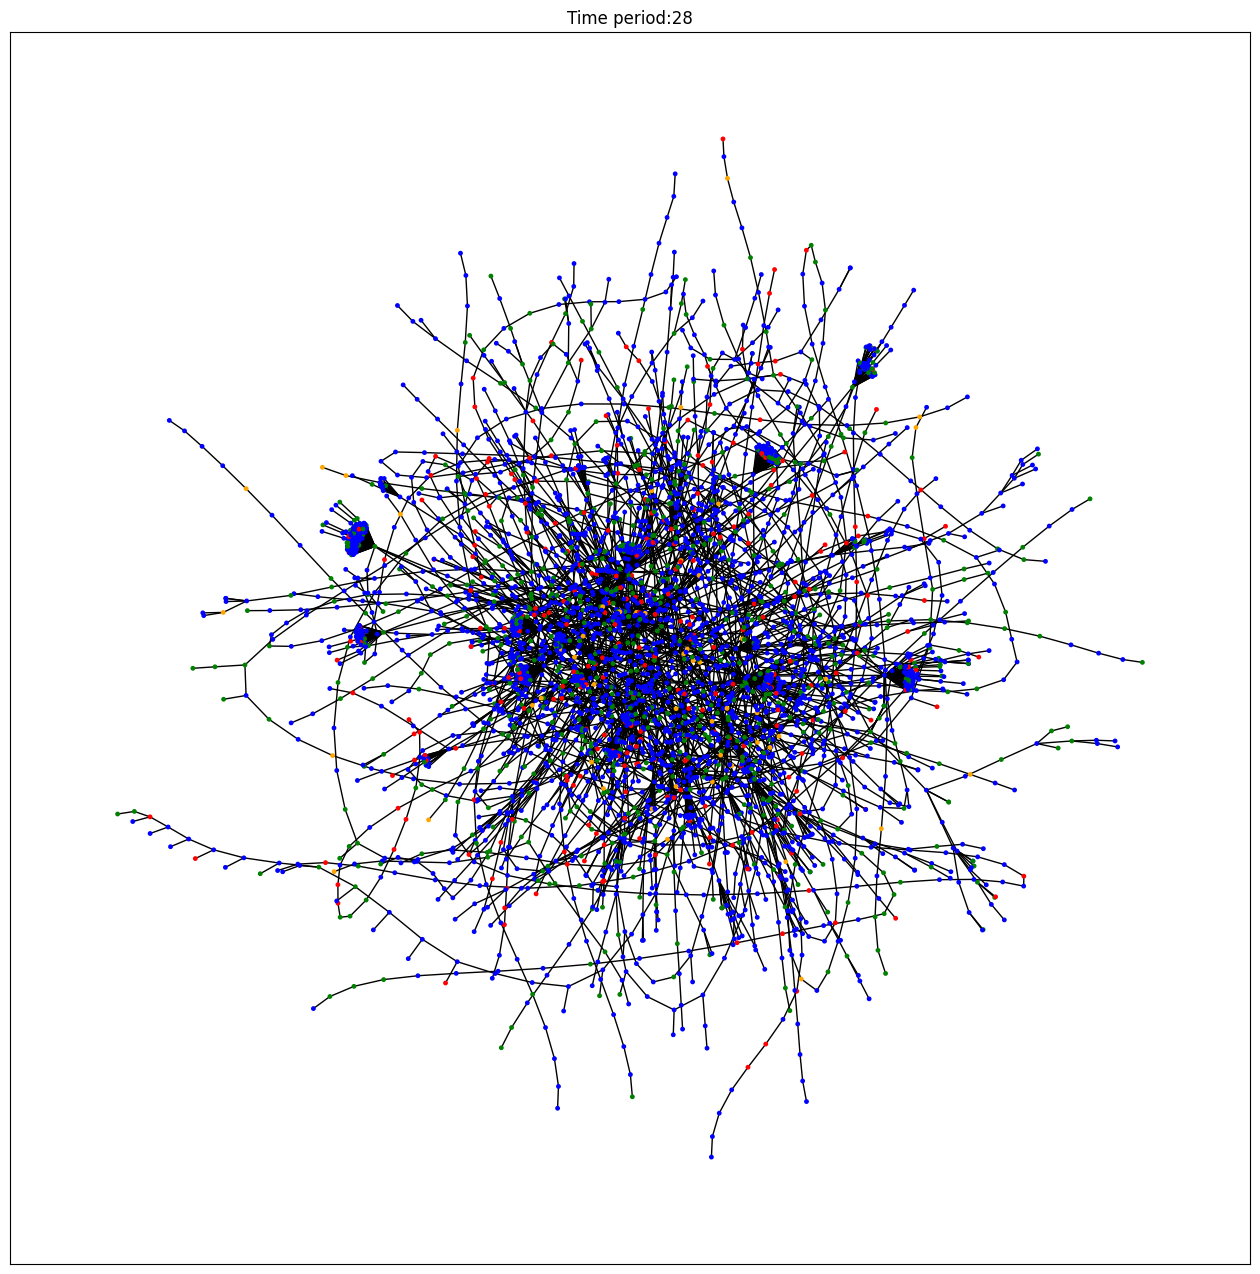

In [212]:
time_period = 28
output = gnn.predict(data=train_data[time_period], unclassified_only=False)

id_to_node = train_data[time_period].id_to_node
edge_index = train_data[time_period].edge_index.cpu().numpy().T

node_color = []
for node_id in id_to_node.keys():
    if node_id in data.classified_illicit_idx:
        label = "red" # fraud
    elif node_id in data.classified_licit_idx:
        label = "green" # fraud
    elif output['pred_labels'][node_id]:
        label = "orange" # Predicted fraud
    else:
        label = "blue" # Not fraud predicted
    node_color.append(label)
    
# Setup networkx graph
G = nx.Graph()
G.add_edges_from(edge_index)

# Plot the graph
plt.figure(3,figsize=(16,16)) 
plt.title("Time period:"+str(time_period))
nx.draw_networkx(G, node_color=node_color, node_size=6, with_labels=False)

The diagram above has the following legend: Green = Not illicit (not fraud), Red = illicit (Fraud), Blue = Predicted not illicit, Orange = Predicted illicit.

## Training Cross comparisons
Here,we show you how to load few results from previous trained models , we should assign names then plots all results. The current visualization has additional models that we ran as well.


In [179]:
# Take names of the saved files
model_name_list = ["GATv2prebuilt.results","GATprebuilt.results","GATmodif.results","GATv2modif.results","GAT_3layers_modif.results"]
#Assign names to plots
names = ["GATv2_prebuilt", "GAT_prebuilt","GAT_custom", "GATv2_custom","GAT_3layers_custom"]

#Iterate to load saved outputs and plots
mm_list0 = [load_results(fn) for fn in model_name_list]
plot_training_comp(mm_list0, names, "aucroc",title="Val set aucroc comparison")

## Best metrics

Next, we show you the best results of each model into a table.

In [180]:
# Plot best results of each into a table
aucroc_l = []
accuracy_l = []
f1micro_l = []
f1macro_l = []
model_versions = []
for c1, mm in enumerate(mm_list0):
  model_versions.append(names[c1])
  best = mm.get_best("aucroc")

  aucroc_l.append(best["aucroc"])
  accuracy_l.append(best["accuracy"])
  f1micro_l.append(best["f1micro"])
  f1macro_l.append(best["f1macro"])

d = {"model_version": model_versions, "aucroc":aucroc_l, "accuracy": accuracy_l, "f1_macro": f1macro_l, "f1_micro": f1micro_l}
df = pd.DataFrame(data=d)

In [181]:
df.round(3)

,model_version,aucroc,accuracy,f1_macro,f1_micro
0,GATv2_prebuilt,0.962,0.916,0.647,0.916
1,GAT_prebuilt,0.979,0.965,0.913,0.965
2,GAT_custom,0.955,0.938,0.786,0.938
3,GATv2_custom,0.639,0.896,0.473,0.896
4,GAT_3layers_custom,0.596,0.896,0.473,0.896
